In [1]:
import pandas as pd
df = pd.read_csv('phase3-var-sel.csv')
df.head()

,MaxLapl,AvgMaxX,MaxVar,LaplVar,SurfNumKP,MaxY,RidgeAreaProp,ORBNumKP,HistMean,MinVar,C1AreaProp,AkazeNumKP,KazeNumKP,MaxAvgLapl,HistVar,Output,Filename
0,255.283676,44643.0,3141.374252,613.496113,103,32988,0.422052,127,172.465515,107.880293,0.353271,4,27,297.757073,720.605256,1,ESP_011314_1585_RED.NOMAP.browse-Block-7.jpg
1,299.942612,595215.0,5497.009506,1075.129234,69,55707,0.238823,27,114.768188,89.108415,0.219666,6,65,601.463473,9042.951879,1,ESP_011325_1845_RED.NOMAP.browse-Block-10.jpg
2,465.874008,378452.0,5698.864609,989.958606,59,36999,0.282823,94,85.229126,141.611445,0.204712,8,61,487.412923,5737.952018,1,ESP_011325_1845_RED.NOMAP.browse-Block-12.jpg
3,374.875717,411315.0,8084.393661,1190.971659,72,42144,0.271832,50,79.706726,182.914684,0.217834,2,60,545.449855,5033.211659,1,ESP_011325_1845_RED.NOMAP.browse-Block-14.jpg
4,109.927353,498016.0,7019.038086,932.756638,65,89109,0.287259,101,93.042786,75.190465,0.218262,5,44,553.311266,6122.234436,1,ESP_011325_1845_RED.NOMAP.browse-Block-16.jpg


In [2]:
groups = df['Filename'].apply(lambda x: x.split('.')[0]).astype('category').cat.codes

In [3]:
from sklearn.model_selection import GroupShuffleSplit

main_x, main_y = df.drop(columns=['Filename', 'Output']).values, df['Output'].values

cv = GroupShuffleSplit(n_splits=2, test_size=0.2, random_state=1337)
train_indices, test_indices = next(cv.split(main_x, main_y, groups))
X, Y = main_x[train_indices], main_y[train_indices]
x_test, y_test = main_x[test_indices], main_y[test_indices]

In [4]:
from scipy.stats import uniform
penalty = ['l1', 'l2']
C = uniform(loc=0, scale=4)
hyperparameters = dict(C=C, penalty=penalty)

In [13]:
groups = df.iloc[train_indices]['Filename'].apply(lambda x: x.split('.')[0]).astype('category').cat.codes

In [14]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

cv = GroupKFold(n_splits=10)
clf = RandomizedSearchCV(LogisticRegression(random_state=1337), hyperparameters, random_state=1337, n_iter=100, cv=cv, verbose=0, n_jobs=-1)
hyp = clf.fit(X,Y,groups=groups)

C:\Users\Michael\Anaconda3\envs\machine-learning\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Michael\Anaconda3\envs\machine-learning\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [15]:
hyp.best_estimator_.get_params()

{'C': 2.082001112704628,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': 1337,
 'solver': 'warn',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


n_classes = 5
y_score = hyp.best_estimator_.decision_function(x_test)
y = label_binarize(y_test, classes=[0, 1, 2, 3, 4])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

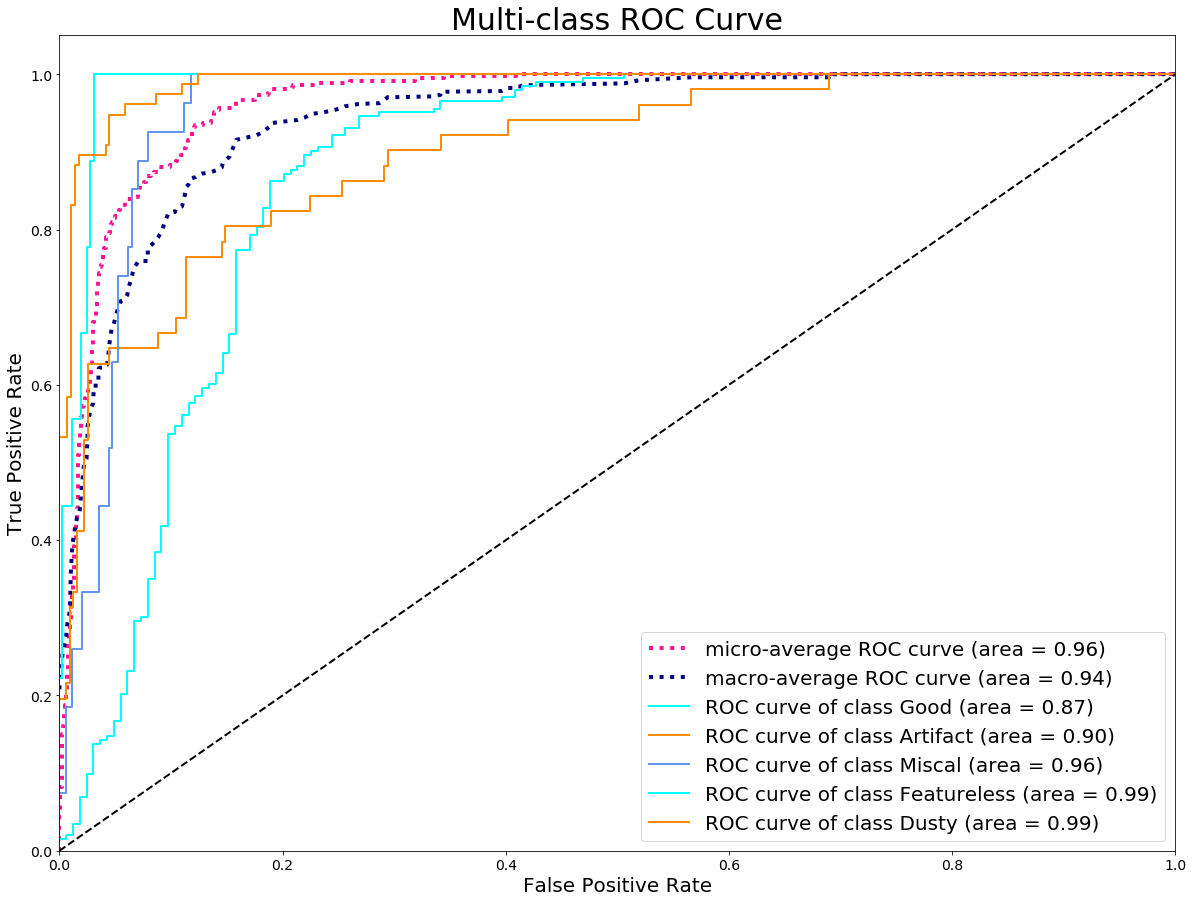

In [26]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
lw=2
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(20,15))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

labels = ['Good', 'Artifact', 'Miscal', 'Featureless', 'Dusty']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('False Positive Rate', size=20)
plt.ylabel('True Positive Rate', size=20)
plt.title('Multi-class ROC Curve', size=30)
plt.legend(loc="lower right", prop={'size': 20})
plt.show()

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_pred = hyp.best_estimator_.predict(x_test)
print("Accuracy: " + str(round(accuracy_score(y_test, y_pred), 2)))
confusion_matrix(y_test, y_pred)

Accuracy: 0.82


array([[197,   2,   0,   1,   3],
       [ 25,  26,   0,   0,   0],
       [  5,   4,   5,   0,  13],
       [  7,   0,   0,   1,   1],
       [  1,   4,   1,   0,  71]], dtype=int64)